**D3APL: Aplicações em Ciência de Dados** <br/>
IFSP Campinas

Prof. Dr. Samuel Martins (Samuka) <br/><br/>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

Target goals:
- Proposed CNN's Architecture
- Dataset Preprocessing
    + Import the image data
    + Preprocessing the data
        - Image rescaling
        - Normalization
    + Save the preprocessed data
    + Convert the images into a _feature matrix (X)_ and a list of _target labels (y)_
- Train CNN
    - Use early stopping regularization
- Evaluate a simple CNN architecture

## 1. Set up

#### 1.1 TensorFlow

In [1]:
import tensorflow as tf

2023-06-10 18:59:35.509313: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 18:59:35.532600: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 18:59:35.532833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 18:59:36.049198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.12.0'

**GPU available?**

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-06-10 18:59:36.712815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-10 18:59:36.713655: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 1.2 Fixing the seed for reproducibility (optional)
That's a try for reprodubility in Keras. See more on:
- https://stackoverflow.com/a/59076062
- https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

In [4]:
import os
import tensorflow as tf
import numpy as np
import random

def reset_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    
# make some random data
reset_random_seeds()

### 1.3 Dataset

In [5]:
import pandas as pd

In [6]:
#from google.colab import drive

#drive.mount('/content/drive2')

In [7]:
dataset_df_train_completo = pd.read_csv('ifsp-d3apl-2023-face-recognition/train.csv')
dataset_df_test = pd.read_csv('ifsp-d3apl-2023-face-recognition/test.csv')

#### 1.3.1 Dataset Info

In [8]:
len(dataset_df_train_completo["label"].unique())

83

In [9]:
# number of samples per class
dataset_df_train_completo["label"].value_counts()

label
Miley Cyrus        278
Lindsay Lohan      267
Jessica Simpson    224
Brad Pitt          224
Avril Lavigne      223
                  ... 
Gordon Brown        66
Ashton Kutcher      65
Jack Nicholson      65
Dustin Hoffman      64
Robert Gates        64
Name: count, Length: 83, dtype: int64

### 1.4. Split the data


Since we will _preprocess the images_, we would like to _keep the pathname_ for the **original images** just in case of recovering them. <br/>
Therefore, we will split the dataset directly from the `Pandas DataFrame`.

We will also defined a _fixed validation set_ for comparison purposes.

In [10]:
from sklearn.model_selection import train_test_split

# for a stratified sampling, we need to pass the labels
labels = dataset_df_train_completo["label"]

dataset_df_train, dataset_df_val = train_test_split(dataset_df_train_completo, test_size=0.2, random_state=42, stratify=labels)

In [11]:
# String base
base_path = "/content/drive2/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/train/"

# Concatenar a string base com os valores da coluna 'PATH'
dataset_df_train_completo['PATH'] = base_path + dataset_df_train_completo['image-pathname']
dataset_df_train['PATH'] = base_path + dataset_df_train['image-pathname']
dataset_df_val['PATH'] = base_path + dataset_df_val['image-pathname']
dataset_df_test['PATH'] = base_path + dataset_df_test['image-pathname']

# Imprimir o DataFrame atualizado
dataset_df_train

,image-pathname,label,PATH
3498,train/Zac Efron/430.jpg,Zac Efron,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
8602,train/Brad Pitt/316.jpg,Brad Pitt,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
9395,train/Sharon Stone/42.jpg,Sharon Stone,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
3891,train/Cristiano Ronaldo/13.jpg,Cristiano Ronaldo,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
6400,train/Charlize Theron/93.jpg,Charlize Theron,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
...,...,...,...
7404,train/Hugh Jackman/200.jpg,Hugh Jackman,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
7519,train/Sania Mirza/39.jpg,Sania Mirza,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
159,train/Shakira/178.jpg,Shakira,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
2962,train/Gwyneth Paltrow/363.jpg,Gwyneth Paltrow,/content/drive2/MyDrive/Colab Notebooks/Kaggle...


In [12]:
dataset_df_train_completo.shape

(9744, 3)

In [13]:
dataset_df_train.shape

(7795, 3)

In [14]:
dataset_df_val.shape

(1949, 3)

## 2. Building and Training a CNN via Keras

### 2.1 Defining the Network Architecture
That's a simple CNN for _Multiclass Classification_:
- **INPUT [64x64x3]**
- CONV [32, 4x4x3, 'valid']
- RELU
- MAX_POOL [2x2, stride=(1,1)]
- CONV [32, 4x4x3, 'valid']
- RELU
- MAX_POOL [2x2, stride=(1,1)]
- FLATTEN
- FC [256]
- RELU
- FC [10, 'softmax']  # number of classes

- optimizer: SGD with `learning_rate=0.01`
- kernel_initializer: "glorot_uniform"
- bias_initializer: "zeros"
- **Early stopping**

In [85]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense


def build_cnn(input_shape=(64, 64, 3), n_classes=10):
    model = Sequential([
        # feature extraction
        Conv2D(filters=32, kernel_size=(4,4), activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Flatten(),
        
        # Fully-Connected Neural Network ==> MLP
        Dense(256, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    
    return model

In [86]:
input_shape = (100, 100, 3)
n_classes = 83

model = build_cnn(input_shape, n_classes)
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 97, 97, 32)        1568      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 32)        16416     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 15488)             0         
                                                                 
 dense_4 (Dense)             (None, 256)              

In [88]:
from tensorflow.keras.utils import plot_model
# vertical
plot_model(model, show_shapes=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### 2.2 Image Preprocessing

In [89]:
import numpy as np

# preprocess the image dataset and return the feature matrix and the label array: X, y
def preprocess_faces_dataset(dataset_df_train_completo, label_encoder, new_img_dims=(100,100), verbose=1000):
    image_list = []  # list of preprocessed images (numpy arrays)
    
    for index, img_path in enumerate(dataset_df_train_completo['PATH']):
        img = cv2.imread(img_path)  # BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB
        
        # image resizing 
        # for gray or color images, the linear interpolation sounds good
        img = cv2.resize(img, new_img_dims, interpolation=cv2.INTER_LINEAR)
        image_list.append(img)
        
        # verbose - print every 1000 iterations
        if index % verbose == 0:
            print(f'{index + 1}/{dataset_df_train_completo.shape[0]} - {img_path}')
    
    # feature matrix
    # shape = (n_imgs, width, height, n_channels)
    X = np.array(image_list)
    
    # feature scaling
    X = X / 255.0
    
    # encoding the classes
    y = label_encoder.transform(dataset_df_train_completo['label'])
    
    return X, y

In [90]:
# training a Label Encoder from the train set
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(dataset_df_train['label'])

LabelEncoder()

In [91]:
dataset_df_train

,image-pathname,label,PATH
3498,train/Zac Efron/430.jpg,Zac Efron,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
8602,train/Brad Pitt/316.jpg,Brad Pitt,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
9395,train/Sharon Stone/42.jpg,Sharon Stone,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
3891,train/Cristiano Ronaldo/13.jpg,Cristiano Ronaldo,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
6400,train/Charlize Theron/93.jpg,Charlize Theron,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
...,...,...,...
7404,train/Hugh Jackman/200.jpg,Hugh Jackman,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
7519,train/Sania Mirza/39.jpg,Sania Mirza,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
159,train/Shakira/178.jpg,Shakira,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
2962,train/Gwyneth Paltrow/363.jpg,Gwyneth Paltrow,/content/drive2/MyDrive/Colab Notebooks/Kaggle...


In [92]:
import cv2
from sklearn.preprocessing import LabelEncoder
import numpy as np


def preprocess_faces_dataset(dataset_df, label_encoder: LabelEncoder, new_img_dims=(64, 64), verbose=0):
  # load the images as a feature matrix
  image_list = []  # list of numpy arrays
    
  for index, img_path in enumerate(dataset_df['image-pathname']):
    img_pathname = ""
    if "train" in img_path:
        img_pathname = "ifsp-d3apl-2023-face-recognition/train/" + img_path
    else:
        img_pathname = "ifsp-d3apl-2023-face-recognition/test/" + img_path
    img = cv2.imread(img_pathname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    # image resizing
    # for gray or color images, the linear interpolation sounds good
    img = cv2.resize(img, new_img_dims, interpolation=cv2.INTER_LINEAR)        
    image_list.append(img)
        
    if verbose and (index % verbose) == 0:
      print(f'{index + 1}/{dataset_df.shape[0]} - {img_pathname}')
    
  # numpy array 4D: n_imgs, height, width, n_channels
  X = np.array(image_list)
    
  # feature scaling
  # numpy arary 4D with values within [0, 1]
  X = X / 255.0
    
  # encoding the classes
  # numpy array 1D with integer labels
  y = label_encoder.transform(dataset_df['label'])
    
  return X, y

In [93]:
# preprocessing the train set
import cv2

# Preprocess the train set
X_train, y_train = preprocess_faces_dataset(dataset_df_train, label_encoder, new_img_dims=(100, 100), verbose=50)

1/7795 - ifsp-d3apl-2023-face-recognition/train/train/Zac Efron/430.jpg
51/7795 - ifsp-d3apl-2023-face-recognition/train/train/Kate Winslet/13.jpg
101/7795 - ifsp-d3apl-2023-face-recognition/train/train/Morgan Freeman/53.jpg
151/7795 - ifsp-d3apl-2023-face-recognition/train/train/Michael Bloomberg/40.jpg
201/7795 - ifsp-d3apl-2023-face-recognition/train/train/Clive Owen/151.jpg
251/7795 - ifsp-d3apl-2023-face-recognition/train/train/Jessica Simpson/81.jpg
301/7795 - ifsp-d3apl-2023-face-recognition/train/train/Lindsay Lohan/125.jpg
351/7795 - ifsp-d3apl-2023-face-recognition/train/train/Denise Richards/250.jpg
401/7795 - ifsp-d3apl-2023-face-recognition/train/train/Daniel Radcliffe/640.jpg
451/7795 - ifsp-d3apl-2023-face-recognition/train/train/Denise Richards/313.jpg
501/7795 - ifsp-d3apl-2023-face-recognition/train/train/Julia Stiles/5.jpg
551/7795 - ifsp-d3apl-2023-face-recognition/train/train/Viggo Mortensen/119.jpg
601/7795 - ifsp-d3apl-2023-face-recognition/train/train/Lindsay Lo

5451/7795 - ifsp-d3apl-2023-face-recognition/train/train/Barack Obama/236.jpg
5501/7795 - ifsp-d3apl-2023-face-recognition/train/train/Angelina Jolie/205.jpg
5551/7795 - ifsp-d3apl-2023-face-recognition/train/train/Leonardo DiCaprio/412.jpg
5601/7795 - ifsp-d3apl-2023-face-recognition/train/train/Tom Cruise/62.jpg
5651/7795 - ifsp-d3apl-2023-face-recognition/train/train/Reese Witherspoon/273.jpg
5701/7795 - ifsp-d3apl-2023-face-recognition/train/train/Barack Obama/142.jpg
5751/7795 - ifsp-d3apl-2023-face-recognition/train/train/Miley Cyrus/445.jpg
5801/7795 - ifsp-d3apl-2023-face-recognition/train/train/Claudia Schiffer/148.jpg
5851/7795 - ifsp-d3apl-2023-face-recognition/train/train/Cameron Diaz/183.jpg
5901/7795 - ifsp-d3apl-2023-face-recognition/train/train/Julia Stiles/134.jpg
5951/7795 - ifsp-d3apl-2023-face-recognition/train/train/Sania Mirza/61.jpg
6001/7795 - ifsp-d3apl-2023-face-recognition/train/train/Meryl Streep/105.jpg
6051/7795 - ifsp-d3apl-2023-face-recognition/train/tra

In [94]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train (classes): {np.unique(y_train)}')
print(f'y_train.shape: {y_train.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

X_train.shape: (7795, 100, 100, 3)
y_train (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
y_train.shape: (7795,)
Min. value of X_train: 0.0
Max. value of X_train: 1.0



In [26]:
!pip install matplotlib

     |████████████████████████████████| 9.2 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 44.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 58.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 49.9 MB/s eta 0:00:01     |█████████████████████           | 2.2 MB 49.9 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 21.0 MB/s eta 0:00:01


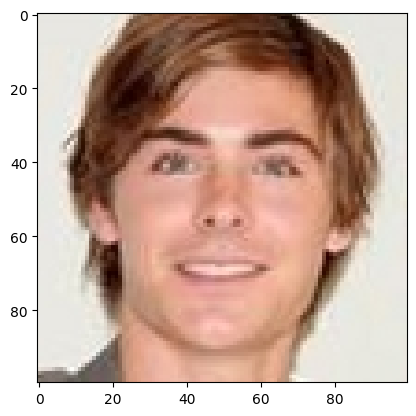

In [95]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

In [96]:
# preprocessing the validation set
X_val, y_val = preprocess_faces_dataset(dataset_df_val, label_encoder, new_img_dims=(100, 100))

In [97]:
print(f'X_val.shape: {X_val.shape}')
print(f'y_val (classes): {np.unique(y_val)}')
print(f'y_val.shape: {y_val.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_val: {X_val.min()}')
print(f'Max. value of X_val: {X_val.max()}\n')

X_val.shape: (1949, 100, 100, 3)
y_val (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
y_val.shape: (1949,)
Min. value of X_val: 0.0
Max. value of X_val: 1.0



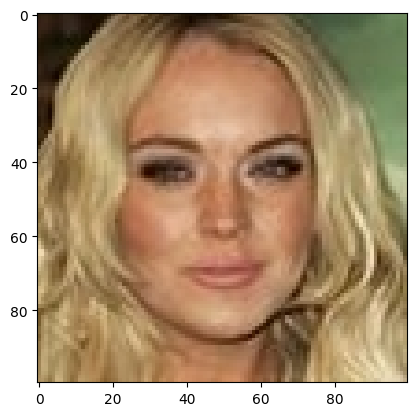

In [98]:
import matplotlib.pyplot as plt
plt.imshow(X_val[0])

#### **Observation**

While _image resizing_ and _feature scaling_ **don't learn** any parameter, our _label encoding_ learns the convertion between _class names_ to _sequential integers_ considering the **entire data**. <br/>
To consider a _real scenario_, we shouldn't do that. We should _split the data_ into _training and testing sets_ ***before* applying any preprocessing** to avoid _snooping bias_. <br/>

One better way is to create a **Scikit-learn `Pipeline`** to _preprocess our data_. For that, we would have to create a _custom sklearn transformer_ to resize the images as well as for the simple feature normalization, and label encoding. Then, we could use this **preprocessing step** in production to preprocess any data!

Another way is consider the _preprocessing steps_ as **layers** from your Neural Network: https://www.tensorflow.org/tutorials/images/data_augmentation

### 2.3 Save the preprocessed data

In [99]:
dataset_df_train

,image-pathname,label,PATH
3498,train/Zac Efron/430.jpg,Zac Efron,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
8602,train/Brad Pitt/316.jpg,Brad Pitt,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
9395,train/Sharon Stone/42.jpg,Sharon Stone,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
3891,train/Cristiano Ronaldo/13.jpg,Cristiano Ronaldo,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
6400,train/Charlize Theron/93.jpg,Charlize Theron,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
...,...,...,...
7404,train/Hugh Jackman/200.jpg,Hugh Jackman,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
7519,train/Sania Mirza/39.jpg,Sania Mirza,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
159,train/Shakira/178.jpg,Shakira,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
2962,train/Gwyneth Paltrow/363.jpg,Gwyneth Paltrow,/content/drive2/MyDrive/Colab Notebooks/Kaggle...


In [100]:
import os

out_dir = 'preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
dataset_df_train_completo.to_csv(os.path.join(out_dir, 'full_train.csv'), index=False)

dataset_df_train.to_csv(os.path.join(out_dir, 'train.csv'), index=False)
np.save(os.path.join(out_dir, 'train_data_64x64x3.npy'), X_train)
np.save(os.path.join(out_dir, 'train_labels.npy'), y_train)

dataset_df_val.to_csv(os.path.join(out_dir, 'validation.csv'), index=False)
np.save(os.path.join(out_dir, 'validation_data_64x64x3.npy'), X_val)
np.save(os.path.join(out_dir, 'validation_labels.npy'), y_val)

#dataset_df_test.to_csv(os.path.join(out_dir, 'test.csv'), index=False)
#np.save(os.path.join(out_dir, 'test_data_64x64x3.npy'), X_test)
#np.save(os.path.join(out_dir, 'test_labels.npy'), y_test)

### 2.5 Training with Early Stopping

In case of GPU drivers, we can monitor its use by [_gpustat_](https://github.com/wookayin/gpustat).

On terminal, use: `gpustat -cpi`


In [101]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [102]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
244/244 [==============================] - 22s 90ms/step - loss: 4.3651 - accuracy: 0.0301 - val_loss: 4.3247 - val_accuracy: 0.0400
Epoch 2/100
244/244 [==============================] - 21s 88ms/step - loss: 4.2879 - accuracy: 0.0441 - val_loss: 4.2422 - val_accuracy: 0.0441
Epoch 3/100
244/244 [==============================] - 22s 89ms/step - loss: 4.1456 - accuracy: 0.0608 - val_loss: 4.0591 - val_accuracy: 0.0883
Epoch 4/100
244/244 [==============================] - 22s 91ms/step - loss: 3.9265 - accuracy: 0.0910 - val_loss: 3.9145 - val_accuracy: 0.1036
Epoch 5/100
244/244 [==============================] - 22s 92ms/step - loss: 3.6963 - accuracy: 0.1315 - val_loss: 3.7348 - val_accuracy: 0.1190
Epoch 6/100
244/244 [==============================] - 23s 94ms/step - loss: 3.4618 - accuracy: 0.1723 - val_loss: 3.5659 - val_accuracy: 0.1478
Epoch 7/100
244/244 [==============================] - 23s 93ms/step - loss: 3.1665 - accuracy: 0.2286 - val_loss: 3.4068 - val_ac

#### **Visualizing the training history**

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

Text(0, 0.5, 'Score')

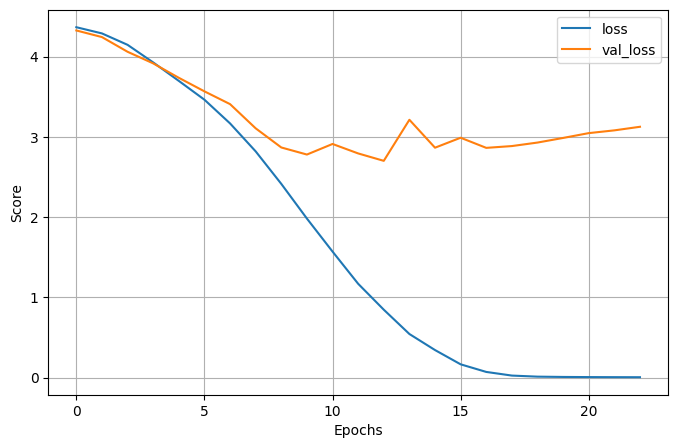

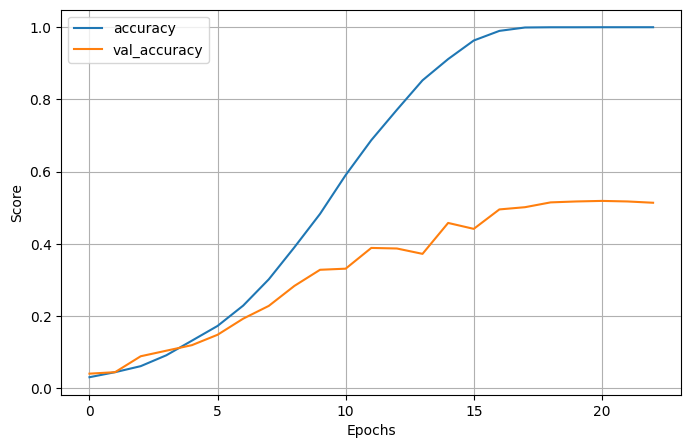

In [104]:
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

In [105]:
y_test_proba = model.predict(X_test)
y_test_pred = np.argmax(y_test_proba, axis=1)
df = pd.DataFrame({"image-id": dataset_df_test["image-id"], "prediction": list(label_encoder.inverse_transform(y_test_pred))})
df.to_csv("results_cnn.csv", index=False)

52/52 [==============================] - 1s 18ms/step


### **Teste**


In [38]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with your dataset
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/100


2023-06-10 19:09:58.776131: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 935400000 exceeds 10% of free system memory.


244/244 [==============================] - ETA: 0s - loss: 3.9982 - accuracy: 0.0802

2023-06-10 19:11:47.396749: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 233880000 exceeds 10% of free system memory.


244/244 [==============================] - 138s 565ms/step - loss: 3.9982 - accuracy: 0.0802 - val_loss: 3.6586 - val_accuracy: 0.1278
Epoch 2/100
244/244 [==============================] - 158s 647ms/step - loss: 3.4203 - accuracy: 0.1648 - val_loss: 3.3288 - val_accuracy: 0.2129
Epoch 3/100
244/244 [==============================] - 162s 663ms/step - loss: 3.1032 - accuracy: 0.2314 - val_loss: 3.0902 - val_accuracy: 0.2519
Epoch 4/100
244/244 [==============================] - 163s 670ms/step - loss: 2.8829 - accuracy: 0.2749 - val_loss: 2.9985 - val_accuracy: 0.2714
Epoch 5/100
244/244 [==============================] - 168s 689ms/step - loss: 2.7136 - accuracy: 0.3126 - val_loss: 2.8695 - val_accuracy: 0.2904
Epoch 6/100
244/244 [==============================] - 171s 703ms/step - loss: 2.5698 - accuracy: 0.3479 - val_loss: 2.8262 - val_accuracy: 0.2817
Epoch 7/100
244/244 [==============================] - 172s 705ms/step - loss: 2.4589 - accuracy: 0.3713 - val_loss: 2.7369 - val_

## 3. Evaluating and Predicting New Samples by using our Overfitted Model

#### **Evaluation**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#evaluate

In [48]:
dataset_df_test

,image-id,image-pathname,PATH
0,1,test/0001.jpg,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
1,2,test/0002.jpg,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
2,3,test/0003.jpg,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
3,4,test/0004.jpg,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
4,5,test/0005.jpg,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
...,...,...,...
1655,1656,test/1656.jpg,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
1656,1657,test/1657.jpg,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
1657,1658,test/1658.jpg,/content/drive2/MyDrive/Colab Notebooks/Kaggle...
1658,1659,test/1659.jpg,/content/drive2/MyDrive/Colab Notebooks/Kaggle...


In [60]:
# X_test, y_test = read_test(dataset_df_test, label_encoder, new_img_dims=(100, 100))

1/1660 - ifsp-d3apl-2023-face-recognition/test/test/0001.jpg
1001/1660 - ifsp-d3apl-2023-face-recognition/test/test/1001.jpg
52/52 [==============================] - 18s 336ms/step


In [61]:
# model.evaluate(X_test, y_test)

52/52 [==============================] - 18s 345ms/step - loss: 1.0429 - accuracy: 1.0000


[1.0428794622421265, 1.0]

#### **Prediction**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict

In [52]:
y_test_proba = model.predict(X_test)
y_test_proba

52/52 [==============================] - 18s 340ms/step


array([[1.6141124e-05, 4.7621520e-06, 7.9244087e-03, ..., 1.3116822e-02,
        3.0042577e-07, 6.4840810e-05],
       [4.1253315e-03, 1.2741251e-03, 8.4978779e-04, ..., 5.9801755e-03,
        3.7544058e-05, 1.6337870e-05],
       [1.2651242e-02, 7.2081680e-06, 6.1992661e-04, ..., 2.1410201e-02,
        6.7786800e-07, 3.1672882e-06],
       ...,
       [7.1932094e-10, 7.8448176e-10, 9.8199304e-03, ..., 1.2212683e-04,
        5.4962174e-10, 5.6024519e-06],
       [6.9598748e-08, 7.0766908e-09, 5.7918630e-03, ..., 2.6168996e-06,
        2.1963857e-07, 5.5681706e-08],
       [6.2982278e-04, 2.9256733e-02, 5.0944542e-03, ..., 7.0200913e-02,
        3.7518833e-03, 5.1757810e-04]], dtype=float32)

#### **Class Prediction**
https://stackoverflow.com/a/69503180/7069696

In [53]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

array([37, 19, 76, ..., 72, 31, 29])

In [54]:
#model.evaluate(X_test, y_test_pred)

52/52 [==============================] - 18s 344ms/step - loss: 1.0429 - accuracy: 1.0000


[1.0428794622421265, 1.0]

In [65]:
#from sklearn.metrics import classification_report

#class_names = label_encoder.classes_

#print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))
list(label_encoder.inverse_transform(y_test_pred))

['Jennifer Aniston',
 'Daniel Craig',
 'Steve Carell',
 'Viggo Mortensen',
 'Silvio Berlusconi',
 'Jessica Simpson',
 'Hugh Laurie',
 'Keira Knightley',
 'Zac Efron',
 'Miley Cyrus',
 'Jessica Simpson',
 'Cristiano Ronaldo',
 'Orlando Bloom',
 'Leonardo DiCaprio',
 'Katherine Heigl',
 'Gwyneth Paltrow',
 'Miley Cyrus',
 'Viggo Mortensen',
 'Jessica Alba',
 'Keira Knightley',
 'Jessica Alba',
 'Ehud Olmert',
 'Orlando Bloom',
 'Jennifer Lopez',
 'Orlando Bloom',
 'Ashton Kutcher',
 'Charlize Theron',
 'Gwyneth Paltrow',
 'David Duchovny',
 'Kate Moss',
 'Silvio Berlusconi',
 'Sharon Stone',
 'Ricky Martin',
 'Cristiano Ronaldo',
 'Miley Cyrus',
 'Morgan Freeman',
 'Dustin Hoffman',
 'Martha Stewart',
 'Harrison Ford',
 'David Beckham',
 'Jessica Alba',
 'Matt Damon',
 'Alec Baldwin',
 'Orlando Bloom',
 'Ashton Kutcher',
 'Eva Mendes',
 'Avril Lavigne',
 'Eva Mendes',
 'Meg Ryan',
 'Tom Cruise',
 'Eva Mendes',
 'George Clooney',
 'Colin Powell',
 'Hugh Jackman',
 'Shakira',
 'Colin Powel

In [73]:
df = pd.DataFrame({"image-id": dataset_df_test["image-id"], "prediction": list(label_encoder.inverse_transform(y_test_pred))})
df.to_csv("results.csv", index=False)

We got a **poor accuracy** of 0.45.

Repeat the experiments considering different:
-  values for _learning_rate_ of SGD
- optimizers (e.g., 'nadam')
- kernel regularizer (e.g., 'l2')
- Dropout regularization

### Modelo 1 ficou ruim, tentativa 2:

In [ ]:
# https://keras.io/api/applications/vgg/
# https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

from tensorflow.keras.applications import VGG16

# consider the original input shape: 224x224x4
base_model = VGG16(include_top=None, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense


model = Sequential([
    # our base model
    base_model,
    
    Flatten(),
    
    # FC classifier
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    
    Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3211392   
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 17,934,986
Trainable params: 3,220,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import math
import cv2


class MyGenerator(Sequence):
    def __init__(self, dataset_df_train_completo, label_encoder, batch_size, new_dims=(100, 100)):
        self.dataset_df_train_completo = dataset_df_train_completo
        self.label_encoder = label_encoder
        self.batch_size = batch_size
        self.new_dims = new_dims
    
    
    def __len__(self):
        n_samples = self.dataset_df_train_completo.shape[0]
        
        return math.ceil(n_samples / float(self.batch_size))
    
    
    def __getitem__(self, idx):
        batch_begin = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size
        
        batch_df = self.dataset_df_train_completo[batch_begin:batch_end]
        
        X_batch, y_batch = preprocess_faces_dataset(batch_df, self.label_encoder, self.new_dims)
                
        return X_batch, y_batch
    

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(dataset_df_train['label'])

LabelEncoder()

In [ ]:
batch_size = 32

training_batch_generator = MyGenerator(dataset_df_train, label_encoder, batch_size, new_dims=(224, 224))
validation_batch_generator = MyGenerator(dataset_df_val, label_encoder, batch_size, new_dims=(224, 224))
test_batch_generator = MyGenerator(dataset_df_test, label_encoder, batch_size, new_dims=(224, 224))

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
history = model.fit(training_batch_generator, epochs=100, validation_data=validation_batch_generator, callbacks=[early_stopping_cb],
                    # Used for generator or keras.utils.Sequence input only
                    use_multiprocessing=True, workers=16, max_queue_size=32)

Error processing image: /content/drive2/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/train/train/Zac Efron/430.jpg. Skipping... Error: 'LABEL'
Error processing image: /content/drive2/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/train/train/Brad Pitt/316.jpg. Skipping... Error: 'LABEL'
Error processing image: /content/drive2/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/train/train/Sharon Stone/42.jpg. Skipping... Error: 'LABEL'
Error processing image: /content/drive2/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/train/train/Cristiano Ronaldo/13.jpg. Skipping... Error: 'LABEL'
Error processing image: /content/drive2/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/train/train/Charlize Theron/93.jpg. Skipping... Error: 'LABEL'
Error processing image: /content/drive2/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/train/train/Denise Richards/32.jpg. Skipping... Error: 'LABEL'
Error pro

InvalidArgumentError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model (without the top fully-connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new fully-connected layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)  # Replace 'num_classes' with the number of classes in your dataset

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resize the input images to match the expected input shape
X_train_resized = tf.image.resize(X_train, (224, 224))
X_val_resized = tf.image.resize(X_val, (224, 224))

# Train the model with your dataset
model.fit(X_train_resized, y_train, epochs=10, batch_size=32, validation_data=(X_val_resized, y_val))

# Evaluate the model on the test set
X_test_resized = tf.image.resize(X_test, (224, 224))
test_loss, test_acc = model.evaluate(X_test_resized, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

NameError: ignored